# Classifying cancer expression vectors

Training a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors.

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [177]:
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  2.1.0+cu121


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [178]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}
for name in y_index_key:
  print(name, y_index_key[name])


Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [179]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for CrossEntropy Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

example dataset


# Define Neural Network Architecture

ShallowLinear class
- init: Initializes the model layers. No inputs except self. Outputs are the initialized layers within the model.
- forward: Performs forward pass through the network. Input is the data x, output is the prediction y_prime.

In [180]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()

        # Define network layer dimensions
        D_in, H1, H2, H3, D_out = [5172, 1024, 512, 256, 46]    # These numbers correspond to each layer: [input, hidden_1, output]

        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(H1, H2)
        self.dropout2 = nn.Dropout(0.35)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.relu(x)       # activation function

        x = self.dropout1(x) # dropout layer

        x = self.linear2(x) # hidden layer
        x = torch.relu(x)       # activation function

        x = self.dropout2(x) # dropout layer

        x = self.linear3(x) # hidden layer
        x = torch.relu(x)       # activation function

        y_prime = self.linear4(x) # output layer

        return y_prime


# Training Function

train() iterates over epochs and batches, updates weights to minimize loss.

Manages the training process over epochs and batches. Inputs include the model, data loader, optimizer, loss function, and number of epochs. Outputs the list of loss values for each batch

In [181]:
def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses

# Batch Training Function

Performs a single forward and backward pass for one batch. Inputs are the model, a batch of data x, corresponding labels y, optimizer, and loss function. Outputs the loss value for the batch.

In [182]:
def train_batch(model, x, y, optimizer, loss_fn):
    ## Note, in practice pytorch can do this all for you in one step, but showing you here to be explicit

    # Run forward calculation
    y_predict = model.forward(x)


    # Convert one-hot vectors back into class indices
    max_values, target_index = y.max(dim=1)
    target_index = target_index.type(torch.LongTensor)

    # Compute loss.
    loss = loss_fn(y_predict, target_index)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()

# Testing Function

Evaluates the model on test data. Inputs are the model and the data loader for test data. Outputs are the true labels and the predicted labels for all test data.

In [183]:

def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_vector = np.concatenate(y_vectors)
    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_vector, y_predict_vector

# Batch Testing Function

Performs a forward pass for one batch of test data. Inputs are the model, a batch of data x, and corresponding labels y. Outputs are the actual labels and the model's predictions.

In [184]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

# Loss Plotting Function

Plots the training loss over time. Input is the list of loss values. No return value; it generates a plot.

In [185]:
def plot_loss(losses):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)
    pyplot.show()
    pyplot.close()

# Run Function

Initializes and executes the training and testing process. Inputs are the training and testing datasets, batch size, and number of epochs. Outputs are the final training losses and the predictions from testing.

In [186]:
def run(dataset_train, dataset_test, batch_size_train = 128, n_epochs = 20):
    # Batch size is the number of training examples used to calculate each iteration's gradient


    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)

    # Define the hyperparameters
    learning_rate = .00003
    shallow_model = ShallowLinear()

    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)

    # Test and get the resulting predicted y values
    y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y_predict


# Declare Dataset & Call run()

In [187]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"

dataset_train = PrimarySiteDataset(x_path=x_train_path, y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path, y_path=y_test_path)

losses, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)




Epoch:  1
Batches:  120
Epoch:  2
Batches:  240
Epoch:  3
Batches:  360
Epoch:  4
Batches:  480
Epoch:  5
Batches:  600
Epoch:  6
Batches:  720
Epoch:  7
Batches:  840
Epoch:  8
Batches:  960
Epoch:  9
Batches:  1080
Epoch:  10
Batches:  1200
Epoch:  11
Batches:  1320
Epoch:  12
Batches:  1440
Epoch:  13
Batches:  1560
Epoch:  14
Batches:  1680
Epoch:  15
Batches:  1800
Epoch:  16
Batches:  1920
Epoch:  17
Batches:  2040
Epoch:  18
Batches:  2160
Epoch:  19
Batches:  2280
Epoch:  20
Batches:  2400


True labels shape: (3826, 46)
Predicted labels shape: (3826, 46)
Final loss: 0.11121374599635601


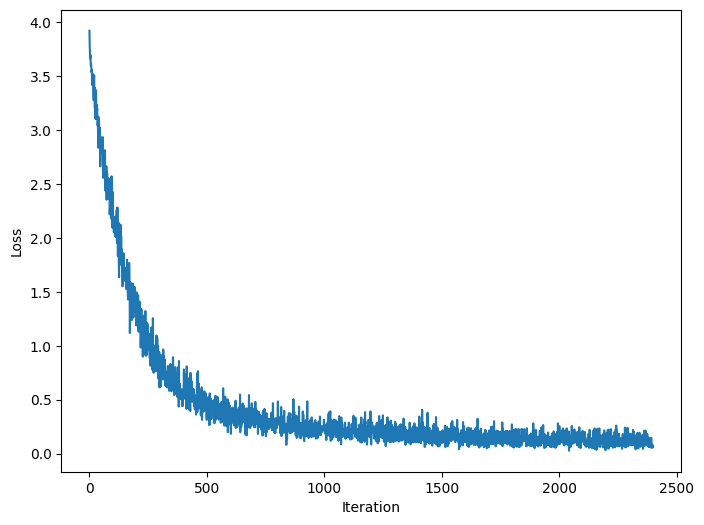

In [188]:
y_true, y_pred = y_predict

print(f'True labels shape: {y_true.shape}')
print(f'Predicted labels shape: {y_pred.shape}')
print("Final loss:", sum(losses[-100:])/100)  # Report the loss
plot_loss(losses) # Plotting the loss function

# Plot Histogram

    Plots the distribution of true and predicted classes.

    Inputs:
    y_true: numpy array, true class labels (one-hot encoded or class indices).
    y_pred: numpy array, predicted class probabilities or class indices.
    num_classes: int, the total number of classes.

    Outputs:
    This function does not return any value. It generates two histograms:
    one for the distribution of true class indices and another for the distribution of predicted class indices.
    It also prints out the shape of the true and predicted class arrays, and the overall classification accuracy.

In [189]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(y_true, y_pred, num_classes):
    """
    Plots the distribution of true and predicted classes.

    Inputs:
    y_true: numpy array, true class labels (one-hot encoded or class indices).
    y_pred: numpy array, predicted class probabilities or class indices.
    num_classes: int, the total number of classes.

    Outputs:
    This function does not return any value. It generates two histograms:
    one for the distribution of true class indices and another for the distribution of predicted class indices.
    It also prints out the shape of the true and predicted class arrays, and the overall classification accuracy.
    """

    # Convert raw predictions to class predictions
    y_pred_argmax = np.argmax(y_pred, axis=1)

    # Convert one-hot encoded true labels to class indices
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Checks if y_true is one-hot encoded
        y_true_argmax = np.argmax(y_true, axis=1)
    else:
        y_true_argmax = y_true

    # Print shapes and first value as examples
    print(f'Shape of y_pred_argmax: {y_pred_argmax.shape}')
    print(f'Shape of y_true_argmax: {y_true_argmax.shape}')
    print(f'First predicted class index: {y_pred_argmax[0]}')
    print(f'First true class index: {y_true_argmax[0]}')

    # Calculate the percentage of correct predictions
    matches = np.sum(y_pred_argmax == y_true_argmax)
    total = len(y_pred_argmax)
    accuracy = matches / total * 100
    print(f'Overall classification accuracy: {accuracy}%')

    # Set up histogram parameters
    bin_edges = np.arange(num_classes + 1) - 0.5
    plt.figure(figsize=(14, 6))

    # Plot histogram for true classes
    plt.subplot(1, 2, 1)
    plt.hist(y_true_argmax, bins=bin_edges, alpha=0.7)
    plt.title('True Class Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Frequency')

    # Plot histogram for predicted classes
    plt.subplot(1, 2, 2)
    plt.hist(y_pred_argmax, bins=bin_edges, alpha=0.7)
    plt.title('Predicted Class Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Plot Confusion Matrix
    """
    Plots a confusion matrix using the true and predicted classifications.

    Inputs:
    y_true: numpy array, true class labels (should be one-hot encoded if more than two classes).
    y_pred: numpy array, predicted class labels or probabilities.
    class_names: list, a list of class names corresponding to the indices in the confusion matrix.

    Outputs:
    This function does not return any value. It generates a heatmap representing the normalized confusion matrix.
    """

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix using the true and predicted classifications.

    Inputs:
    y_true: numpy array, true class labels (should be one-hot encoded if more than two classes).
    y_pred: numpy array, predicted class labels or probabilities.
    class_names: list, a list of class names corresponding to the indices in the confusion matrix.

    Outputs:
    This function does not return any value. It generates a heatmap representing the normalized confusion matrix.
    """

    # Convert one-hot encoded labels to class indices if necessary
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # Convert predicted probabilities to class indices
    y_pred_indices = np.argmax(y_pred, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred_indices)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Set up the matplotlib figure and axes
    plt.figure(figsize=(25, 18))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)

    # Labeling the plot
    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f'{cm_normalized[i, j]:.2f}',
                ha="center", va='center',
                color="white" if cm_normalized[i, j] > thresh else "black")

    # Setting the title and labels
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Tick marks and settings
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90, ha='center')
    plt.yticks(tick_marks, class_names, va='center')

    plt.grid(False)
    plt.tight_layout()
    plt.show()


# Questions & Answers



## Part 1:

### 1. How many training examples are in the dataset?  
- There are 15,300 training datapoints

### 2. What proportion (%) of the full dataset has been set aside for testing?
- Proportion for testing =  (3,826/(15,300+3,826)) x 100 = 20.004% for testing
~80/20 train/test split

### 3. How many gene expression values will be used as input to classify each sample in the  dataset?
- There are 5,172 gene expression values used as input features.

### 4. How many tissue types are there in the data labels?
- There are 46 different tissue types.

### 5. When performing classification with a neural network, the output vector is an array with  n variables, where each variable describes the probability that your input belongs to one  class in your classification problem. Based on this information, what should be the size  of your output layer in the neural network?
- The size of the output layer should be 46, corresponding to the # of tissue types.

### 6. How will you know which index in the output corresponds to which tissue type once you  feed your data into the model and get your output?
- The index in the output will correspond to the tissue type as per the mapping provided in cell 1 output. For example, if the output neuron with the highest probability is at index 0, it corresponds to 'Adipose Tissue'; if it's at index 1, it corresponds to 'Adrenal Gland', and so on.


## Part 2:

### 1. Methods and Explanations
- (See section headers)

### 2. Flowchart image:
- https://drive.google.com/file/d/1SejTHmcjLjh1re40QwgYCtReEXN1xXPG/view?usp=sharing

## Part 3:

### 1. Changes made to define loss.
- No change required, loss started as <1


### 2. Comparing predictions to expected
- True labels shape: (3826, 46)
- Predicted labels shape: (3826, 46)

### 3. Do these match test set size from part 1
- Yes!

### 4. Table of first training example

In [191]:
# Create a DataFrame
df = pd.DataFrame({
    'Class Index': np.arange(1, 47),  # Adjust based on your number of classes
    'Predicted Probability': y_predict[0][0],
    'True Label': y_predict[1][0]

})

# Display the DataFrame
print(df)

    Class Index  Predicted Probability  True Label
0             1                    0.0   -3.479383
1             2                    0.0   -1.267560
2             3                    0.0   -3.686932
3             4                    0.0    0.829176
4             5                    0.0   -5.516022
5             6                    0.0   -4.588551
6             7                    0.0   -0.369538
7             8                    0.0   -4.625910
8             9                    1.0   16.879925
9            10                    0.0  -11.443473
10           11                    0.0   -5.238880
11           12                    0.0    1.181431
12           13                    0.0   -7.725012
13           14                    0.0   -4.783741
14           15                    0.0   -2.206256
15           16                    0.0   -1.400780
16           17                    0.0    1.652004
17           18                    0.0   -3.655546
18           19                

### 5.
- First value of y_argmax: 8
- First value of y_predict_argmax: 8
- The relationship between these values and my #4 table makes sense. The first value of y_pred_argmax coincides with the highest predicted probability in #4, and y_true_argmax represents the correct classification of the entry used for the table.

### 6. Overall Classification Accuracy
- 0.705697856769472% (generated incorrectly)
- 94.6% (upon correcting above error)

### 7. Plot a histogram of your argmax values for y, and for predicted y. How do they compare? In which scenarios would you expect your predicted distribution to match or not match your true distribution?



Shape of y_pred_argmax: (3826,)
Shape of y_true_argmax: (3826,)
First predicted class index: 8
First true class index: 8
Overall classification accuracy: 96.18400418191322%


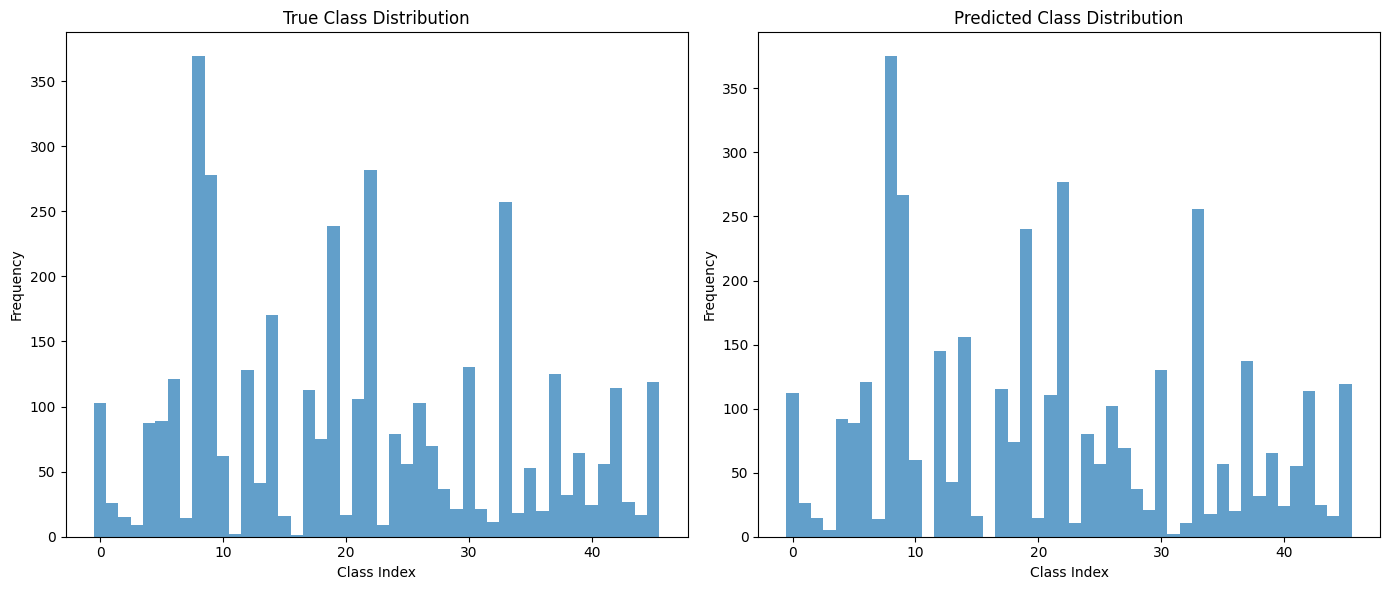

In [192]:
plot_histogram(y_predict[0], y_predict[1], len(y_index_key))

- Initially, my histogram of predicted values had a peak of 3,000 in a single class, with an accuracy of 0.7% In that case, the histograms were radically different. The generated histogram is based on my higher accuracy model. The histogram for predicted y is very similar to the histogram for my argmax values. Because my prediction is high accuracy (>95%), I expect the predicted distribution to match the true distribution. As accuracy wanes, via over/under-fitting, I expect the distributions to begin to differ, as the predicted distribution likely has higher peaks of misclassified data in specific classes.

## Part 4:
- No written section.

## Part 5:
### 1. Make a normalized confusion matrix with your results, and plot it as a heat map (pyplot.imshow). Make sure the axis are labelled either with the text name of each class or something that will allow you to look up the class name.


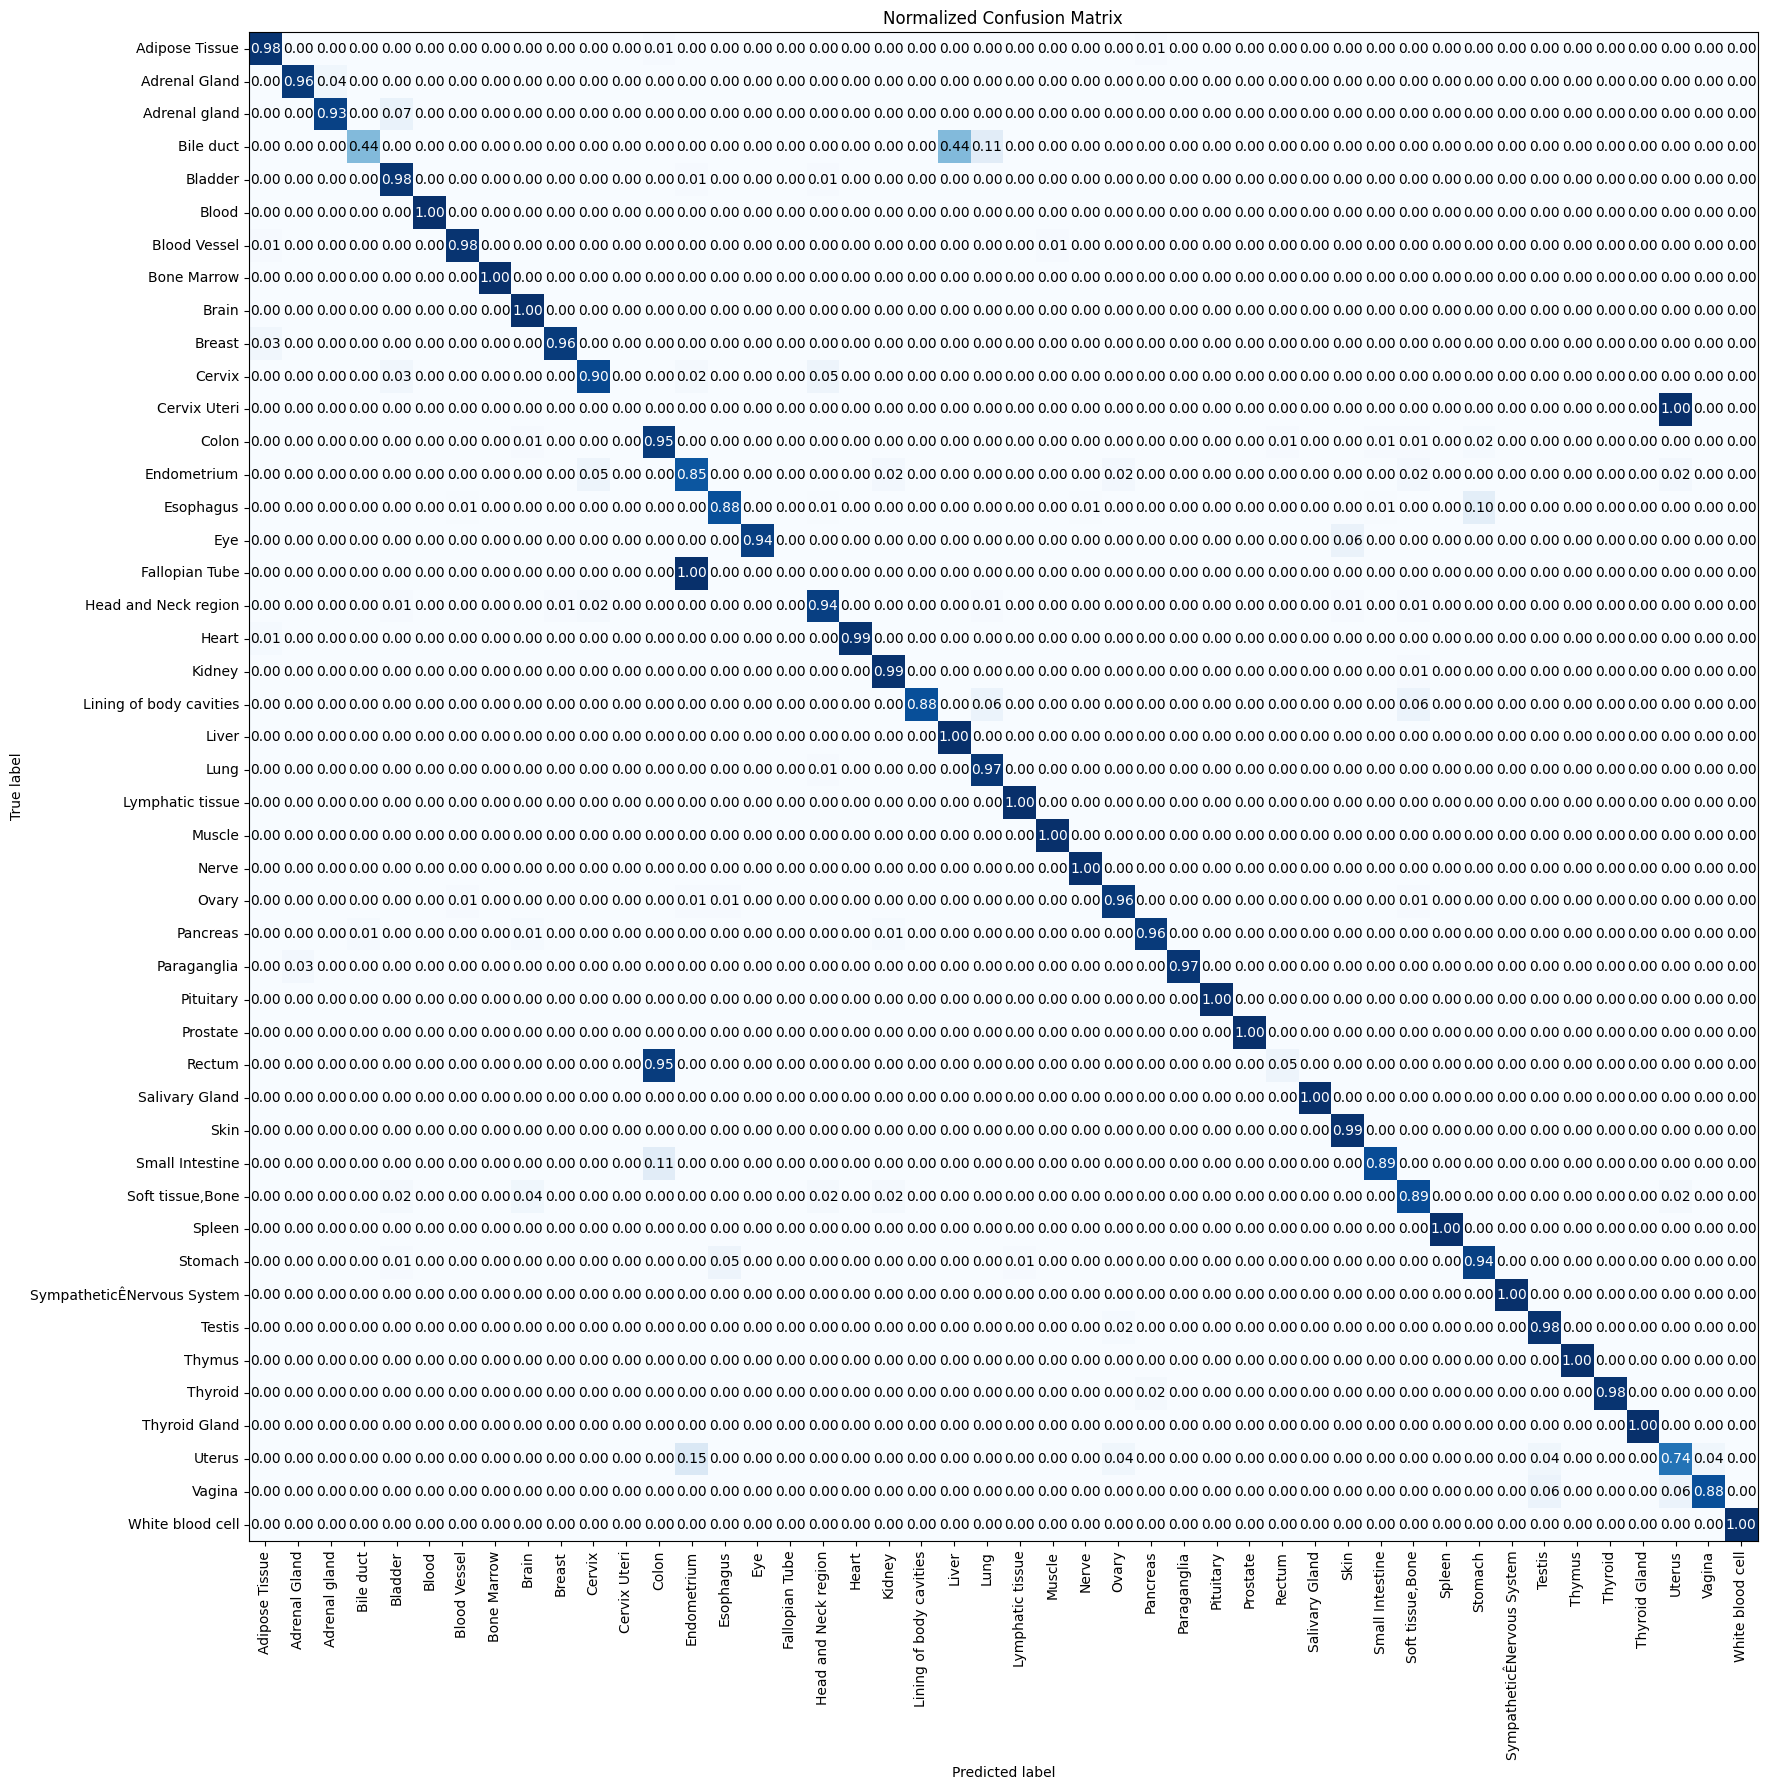

In [211]:
plot_confusion_matrix(y_predict[0], y_predict[1],y_index_key.keys())




### 2. Once you have something you are satisfied with, report how the data was processed (if different from the provided script), your architecture, and your training parameters.
- The data was processed similar to the provided script, gene expression vectors subsetted to KEGG gene set
- My new architecture had these dimensions: [5172, 1024, 512, 256, 46]
  - I added 2 dropout layers between linear layers 1, 2, & 3. The first dropout had a value of 0.5, while the second was 0.35
- Training Parameters: batch_size=128, lr=0.00003, epochs=20

\\
### 3. What is your final accuracy (overall percent)?
- The final accuracy I was able to acheive was 96.184%

\\
### 4. What tissue types were most “confusing” for the model? Answer in terms of which classes were most inter-confused, and quantitative accuracy for each of the most confused classes. You may use this method to compute quantitative stats for each class.
- The most confusing classes for my model were:
  - Bile duct:      f1 = 0.57, precision = 0.80, recall = 0.40
    - When the model predicts Bile Duct, it is 80% accurate
    - The model only identifies 44% of Bile Duct instances
  - Cervix Uteri:   f1 = 0.00, precision = 0.00, recall = 0.00
  - Fallopian Tube: f1 = 0.00, precision = 0.00, recall = 0.00
  - Rectum:         f1 = 0.09, precision = 0.50, recall = 0.05
- The most inter-confused classes were (-> represents 'confused for'):
  - Fallopian Tube -> Endometrium: [1.00]
  - Cervix Uteri -> Uterus: [1.00]
  - Rectum -> Colon: [0.95]
  - Bile Duct -> Liver: 0.44

In [197]:
from sklearn.metrics import classification_report

# Generate the report
report = classification_report(np.argmax(y_predict[0], axis=1), np.argmax(y_predict[1], axis=1), target_names=list(y_index_key.keys()))

# Print the report
print(report)


                            precision    recall  f1-score   support

            Adipose Tissue       0.90      0.98      0.94       103
             Adrenal Gland       0.96      0.96      0.96        26
             Adrenal gland       0.93      0.93      0.93        15
                 Bile duct       0.80      0.44      0.57         9
                   Bladder       0.92      0.98      0.95        87
                     Blood       1.00      1.00      1.00        89
              Blood Vessel       0.98      0.98      0.98       121
               Bone Marrow       1.00      1.00      1.00        14
                     Brain       0.98      1.00      0.99       369
                    Breast       1.00      0.96      0.98       278
                    Cervix       0.93      0.90      0.92        62
              Cervix Uteri       0.00      0.00      0.00         2
                     Colon       0.84      0.95      0.89       128
               Endometrium       0.81      0.85

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))





\\
### 5. How does each class's frequency correlate (if at all) to the model's performance for that class, qualitatively or quantitatively?
- The classes that most confused my model were also some of the lowest frequency classes. It seems that classes with limited training data are difficult for the model to predict. I surmise that this trend may also be impacted by the low support for each of these classes (9, 2, 1, 21, in respect to Q4). Since there are fewer instances, each misclassification has a steeper impact on the precision & recall.

\\
### 6. Describe your strategy for choosing hyperparameters. Did you use any form of evaluation to inform your decisions? If you have recorded the steps you took to reach your final configuration, write them here.
- For choosing my learning rate, I kept reducing it until the loss_plot had less intense peaks/valleys as it decreased.
- For the rest of my hyperparameters, I used trial and error to determine if changes made were positive or negative. Due to miscalculation of my model accuracy, some of these changes may not have been truly beneficial.
  - lr=1e-3, Dropout(0.5), batch=128, acc=~3%
  - lr=1e-4, Dropout(0.5)x2, batch=128, acc=~1.96
  - lr=0.0005, Dropout(0.5), Dropout(0.35), batch=128, acc=~94.6

\\
### 7. Assume you have a network with the following dimensions:
- Input: 32 nodes
- Hidden: 64 nodes
- Output: 4 nodes
### What is the total number of weight parameters you are optimizing? What is the total number of bias parameters you are optimizing? For your network, how many weight parameters are you optimizing? How does this compare to the number of training examples in your dataset?
- Total number of weight parameters: 2,304
- Total number of bias parameters: 68
- For my network
  - Optimizing 5,963,264 weight parameters
  - For 3826 training examples


\\
### 8. Given these numbers, do you think there is any risk of overfitting? Considering the size and diversity of this test set would you be confident that this model will generalize to all future data you might encounter?
- Considering the # of parameters vs. the size of my dataset, there is definitely a risk of overfitting, especially considering the extra layers added to my model. However, my addition of 2 dropout layers may serve to reduce the risk of overfitting, so I would be somewhat confident in my model's ability to generalize.

\\
### 9. Do you think there is a better combination of hyperparameters (not model parameters) with respect to the test results? Are there any obvious shortcomings in your opinion? If you had infinite time/resources how might you improve your methods?
- There are likely many better combinations of hyperparameters. I tuned my hyperparameters with a flawed accuracy calculation, so my approach to improving their values was very flawed. With more time, implementing an automated hyperparameter tuning method such as grid search may yield the best possible combination.

\\
### 10. Other than the hyperparameters, what might affect this model's performance?
- The architecture of the model impacts the model's performance. The dropout values in each of the dropout layers impacts the model's resistance to overfitting, and the amount of layers impact the complexity of the patterns identified. Additionally, data diversity can alter how the model behaves, and regularization techniques may aid in preventing overfitting as well.

\\
### 11. You may have noticed that the “adrenal gland” tissue label is duplicated. If your model is actually separating them, what might that indicate about its ability to generalize to new “adrenal gland” tissue types?
- If my model is separating "Adrenal gland" and "Adrenal Gland", it may indicate that my model is overfit to the specific patterns of the provided data and mislabeling trends, as opposed to meaningful biological differences. However, my model's separation of adrenal gland variations may indicate an ability to correctly classify different types of adrenal gland tissues. This reinforces the need for data cleaning, as consistent labeling might resolve this confusion.